In [ ]:
import torch
import matplotlib.pyplot as plt
from torch import tanh

In [ ]:
# this is my attempt to implement simple RNN architecture
class SimpleRNN:
    def __init__(self, x, y):
        self.x = x
        self.y = y

        # Initialize weights and biases
        torch.manual_seed(42)
        self.w_x = torch.randn(1, requires_grad=True)
        self.w_h = torch.randn(1, requires_grad=True)
        self.w_y = torch.randn(1, requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)
        self.b_y = torch.zeros(1, requires_grad=True)
        self.hs = []

    def compute_hs(self):
        self.hs = [torch.zeros_like(self.w_h)]
        for t in range(len(self.x)):
            prev_h = self.hs[t]
            # Remove relu or tanh activation incase true is linear
            h_t = torch.relu(self.w_x * self.x[t] + self.w_h * prev_h + self.b)
            self.hs.append(h_t)
        return self.hs

    def compute_y_pred(self):
        self.y_pred = []
        for t in range(len(self.x)):
            y_n = self.w_y * self.hs[t + 1] + self.b_y
            self.y_pred.append(y_n)
        self.y_pred = torch.stack(self.y_pred).squeeze()
        return self.y_pred

    def forward(self):
        lr = 0.01  # Adjusted learning rate
        loss = float('inf')
        change_loss = float('inf')
        epoch = 0
        max_epochs = 5000  # Increased epochs for convergence
        while change_loss > 0.000001 and epoch < max_epochs:
            # Ensure weights require gradients
            self.w_x.requires_grad_()
            self.w_h.requires_grad_()
            self.w_y.requires_grad_()
            self.b.requires_grad_()
            self.b_y.requires_grad_()

            # Forward pass
            self.compute_hs()
            self.compute_y_pred()

            # Compute loss
            loss_t = ((self.y_pred - self.y) ** 2).mean()

            # Backward pass
            loss_t.backward()

            # Update weights
            with torch.no_grad():
                self.w_x -= lr * self.w_x.grad
                self.w_h -= lr * self.w_h.grad
                self.w_y -= lr * self.w_y.grad
                self.b -= lr * self.b.grad
                self.b_y -= lr * self.b_y.grad

                # Zero gradients after updating
                self.w_x.grad.zero_()
                self.w_h.grad.zero_()
                self.w_y.grad.zero_()
                self.b.grad.zero_()
                self.b_y.grad.zero_()

            change_loss = abs(loss - loss_t.item())
            loss = loss_t.item()
            epoch += 1

            # Optional: print debug information
            if epoch % 500 == 0 or epoch == 1:
                print(f"Epoch {epoch}: Loss={loss:.6f}")

        return self.w_x, self.w_h, self.b, self.w_y, self.b_y, loss


In [ ]:
# Initialize inputs
torch.manual_seed(42)
x = torch.randint(1, 10, (100,)).float()
y = x ** 2 + 3

# Normalize inputs and outputs
x_mean = x.mean()
x_std = x.std()
x_normalized = (x - x_mean) / x_std

y_mean = y.mean()
y_std = y.std()
y_normalized = (y - y_mean) / y_std

In [ ]:
# Train RNN
back_propagation = SimpleRNN(x_normalized, y_normalized)
w_x, w_h, b, w_y, b_y, loss = back_propagation.forward()

# Final predictions
final_y_pred_normalized = back_propagation.compute_y_pred()

# Denormalize predictions
final_y_pred = final_y_pred_normalized * y_std + y_mean

print(f"Final Loss: {loss:.6f}")
print(f"First 10 Original y: {y[:10]}")
print(f"First 10 Predicted y: {final_y_pred[:10].detach()}")

Epoch 1: Loss=0.899469
Epoch 500: Loss=0.021911
Epoch 1000: Loss=0.011423
Final Loss: 0.011111
First 10 Original y: tensor([52., 39., 67., 28.,  4., 12., 67., 39., 28., 12.])
First 10 Predicted y: tensor([55.1343, 41.3368, 67.5735, 28.1232,  8.7195,  8.7195, 68.1341, 41.1134,
        28.5779,  8.7195])


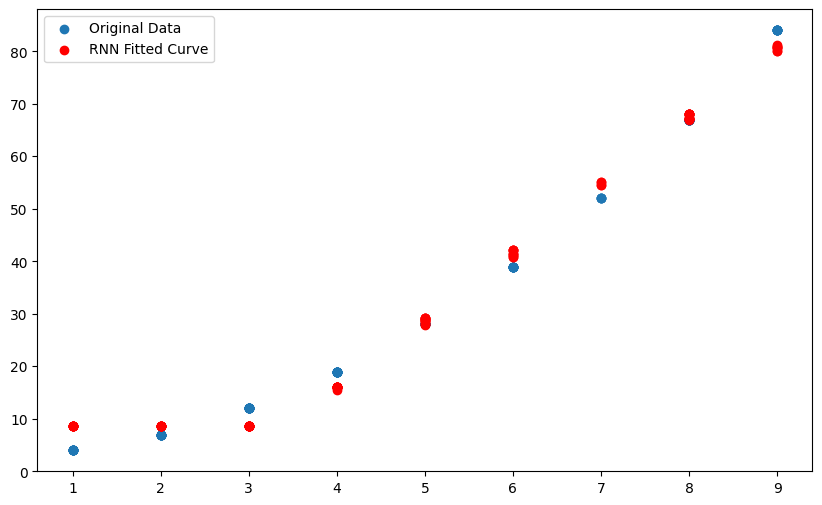

In [ ]:
#plot y , y_pred and x

plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Original Data')
plt.scatter(x, final_y_pred.detach(), color='red', label='RNN Fitted Curve')
plt.legend()
plt.show()